In [15]:
import itertools
import pathlib
from pathlib import Path
from typing import Optional, List

import yaml
import dataclasses
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms

import lab.metrics
import lab.analytics

sns.set_style("white")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

In [16]:
@dataclasses.dataclass
class PlotConfig:
    # Each entry corresponds to an axis with the sub-dictionaries
    # storing mappings of labels to filenames 
    layout: dict
    # The path to store  
    output_files: List[pathlib.Path]
    # Line styles for the various labels
    line_styles: dict = dataclasses.field(default_factory=dict)
    # True if a legend should be added
    with_legend: bool = True
    
    @classmethod
    def from_snakemake(cls):
        return cls(
            layout=snakemake.params["layout"],
            output_files=[Path(p) for p in snakemake.output],
            line_styles=snakemake.params.get("line_styles", {}),
            with_legend=snakemake.params.get("with_legend", False),
        )
    
    def savefig(self, fig, *args, **kwargs):
        for path in self.output_files:
            if path.suffix in (".pdf", ".pgf") and "backend" not in kwargs:
                kwargs["backend"] = "pgf"
            fig.savefig(path, *args, **kwargs)
    

if "snakemake" in globals():
    config = PlotConfig.from_snakemake()
else:
    config = PlotConfig({
            "VarCNN": {
                "defended": "../../results/ml-eval-conn/defence~front/classifier~varcnn-sizes/predictions.csv",
                "undefended": "../../results/ml-eval-conn/defence~undefended/classifier~varcnn-sizes/predictions.csv",
                "skip-tuning": "../../predictions.csv"
            },
            "$k$-FP": {
                "undefended": f"../../results/ml-eval-conn/defence~undefended/classifier~kfp/predictions.csv",
                "defended": "../../results/ml-eval-conn/defence~tamaraw/classifier~kfp/predictions.csv",
                "QCSD+": "../../results/improved-tamaraw/conn~single/defence~tamaraw/classifier~kfp/predictions.csv",
            }
        },
        [Path("/tmp/plot.png")],
        line_styles={"defended": "-", "undefended": "--", "skip-tuning": ":", "QCSD+": "-."}
    )

In [17]:
def _load_data(inputs):
    return (
        pd.concat([
            pd.read_csv(filename, header=0).assign(title=axes_title, label=label).set_index(["title", "label"], append=True)
            for (axes_title, lines) in inputs.items()
            for (label, filename) in lines.items()
        ])
        .fillna(0)
        .rename(columns=lambda c: int(c) if c != "y_true" else c)
        .astype({"y_true": int})
        .drop(columns=[-1])
    )

data = _load_data(config.layout)
data

,,,y_true,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
,title,label,,,,,,,,,,,,,,,,,,,,,
0,VarCNN,defended,-1,0.002363,0.004005,0.016510,0.001324,0.003017,0.009987,0.013603,0.010490,0.002562,...,0.001566,0.002323,0.003302,0.004070,0.011024,0.018234,0.005516,0.001503,0.009232,0.001801
1,VarCNN,defended,22,0.003345,0.005276,0.016266,0.000942,0.001609,0.011002,0.017044,0.007408,0.002571,...,0.002823,0.003452,0.005074,0.005245,0.011551,0.015572,0.011627,0.003040,0.007786,0.001781
2,VarCNN,defended,25,0.004890,0.012047,0.010399,0.008263,0.020264,0.015823,0.005226,0.015053,0.005867,...,0.004128,0.010109,0.006599,0.006477,0.008469,0.011826,0.005302,0.002962,0.012718,0.007519
3,VarCNN,defended,43,0.007759,0.015556,0.002991,0.002655,0.006584,0.010811,0.007042,0.026367,0.011993,...,0.011635,0.010880,0.006020,0.009087,0.011292,0.010231,0.018219,0.003145,0.014458,0.001842
4,VarCNN,defended,72,0.025009,0.012787,0.004848,0.005840,0.023315,0.007904,0.004555,0.029785,0.015434,...,0.009941,0.005234,0.004860,0.018616,0.009903,0.008957,0.012291,0.002472,0.014793,0.001409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,$k$-FP,QCSD+,92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1096,$k$-FP,QCSD+,99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1097,$k$-FP,QCSD+,83,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [54]:
def _load_data(inputs):
    return (
        pd.concat([
            pd.read_csv(filename, header=0).assign(title=axes_title, label=label).set_index(["title", "label"], append=True)
            for (axes_title, lines) in inputs.items()
            for (label, filename) in lines.items()
        ])
        .fillna(0)
        .rename(columns=lambda c: int(c) if c != "y_true" else c)
        .astype({"y_true": int})
    )

data2 = _load_data(config.layout)
data2["y_pred"] = data2.iloc[:, 1:].idxmax(axis=1)
data2

,,,y_true,-1,0,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,y_pred
,title,label,,,,,,,,,,,,,,,,,,,,,
0,VarCNN,defended,-1,0.004299,0.002363,0.004005,0.016510,0.001324,0.003017,0.009987,0.013603,0.010490,...,0.002323,0.003302,0.004070,0.011024,0.018234,0.005516,0.001503,0.009232,0.001801,72
1,VarCNN,defended,22,0.002169,0.003345,0.005276,0.016266,0.000942,0.001609,0.011002,0.017044,0.007408,...,0.003452,0.005074,0.005245,0.011551,0.015572,0.011627,0.003040,0.007786,0.001781,78
2,VarCNN,defended,25,0.005096,0.004890,0.012047,0.010399,0.008263,0.020264,0.015823,0.005226,0.015053,...,0.010109,0.006599,0.006477,0.008469,0.011826,0.005302,0.002962,0.012718,0.007519,21
3,VarCNN,defended,43,0.017899,0.007759,0.015556,0.002991,0.002655,0.006584,0.010811,0.007042,0.026367,...,0.010880,0.006020,0.009087,0.011292,0.010231,0.018219,0.003145,0.014458,0.001842,13
4,VarCNN,defended,72,0.016068,0.025009,0.012787,0.004848,0.005840,0.023315,0.007904,0.004555,0.029785,...,0.005234,0.004860,0.018616,0.009903,0.008957,0.012291,0.002472,0.014793,0.001409,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,$k$-FP,QCSD+,92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92
1096,$k$-FP,QCSD+,99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,99
1097,$k$-FP,QCSD+,83,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83


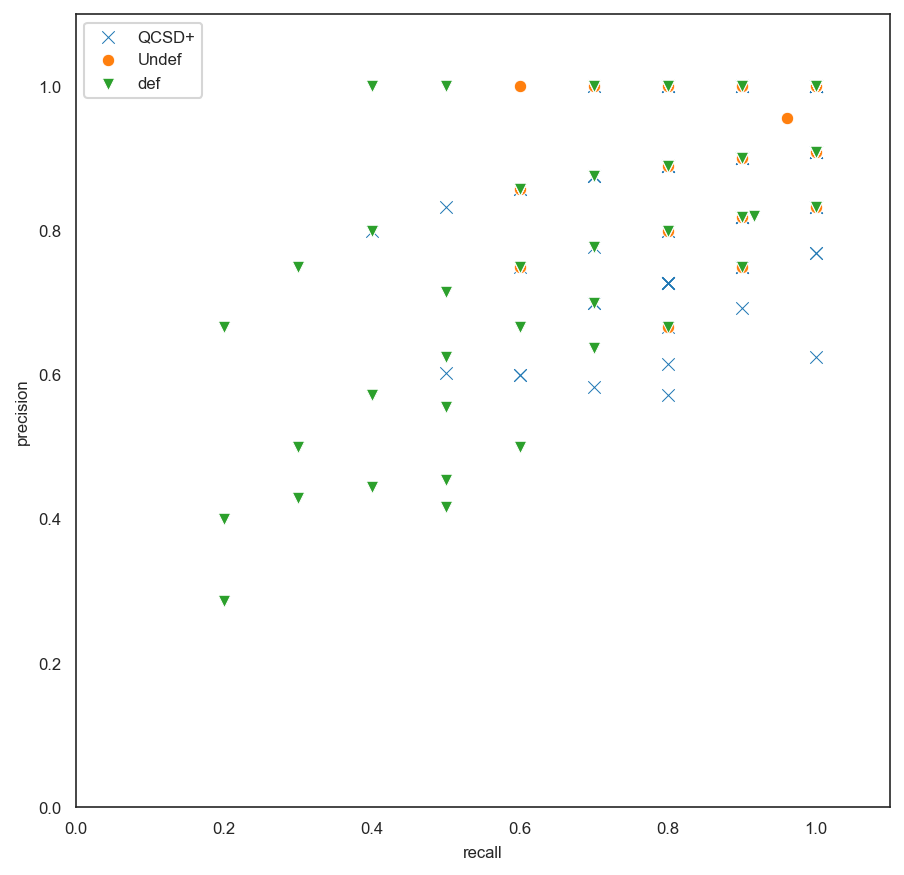

In [84]:
columns = np.arange(-1, 100, 1)

plot_data2 = data2.query("(title=='$k$-FP') & (label=='QCSD+')")
plot_data3 = data2.query("(title=='$k$-FP') & (label=='undefended')")
plot_data4 = data2.query("(title=='$k$-FP') & (label=='defended')")

from sklearn import metrics
# plot_data2 = pd.DataFrame(np.log1p(confusion_matrix(data2["y_true"], y_pred)), columns=columns, index=columns )
# plot_data2
# 
fig, axes = plt.subplots(1, 1, figsize=(7, 7), dpi=150)
for data, marker, label in zip([plot_data2, plot_data3, plot_data4], ['x', 'o', 'v'], ["QCSD+", "Undef", "def"]):
    data = pd.DataFrame({
        "precision": pd.Series(metrics.precision_score(data["y_true"], data["y_pred"], average=None), index=columns),
        "recall": pd.Series(metrics.recall_score(data["y_true"], data["y_pred"], average=None), index=columns),
    })
    sns.scatterplot(data=data, y="precision", x="recall", ax=axes, marker=marker, label=label)
axes.set_xlim(0, 1.1)
axes.set_ylim(0, 1.1)
axes.legend()



In [68]:
def precision_recall_curve(df):
    result = lab.analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)
    return pd.DataFrame({"precision": result.precision, "recall": result.recall})

pr_scores = data.groupby(["title", "label"]).apply(lambda x: precision_recall_curve(x))
pr_scores

TypeError: rprecision_recall_curve() got an unexpected keyword argument 'zero_division'

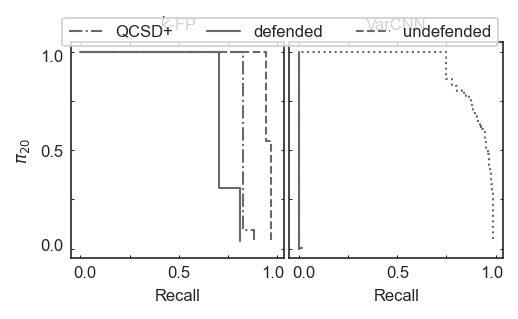

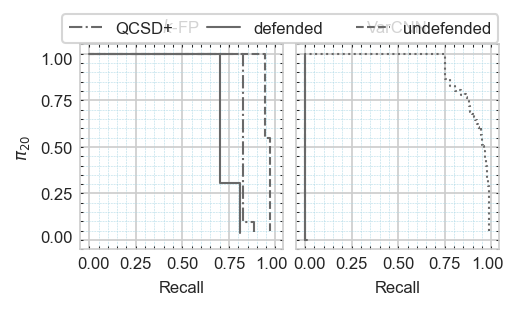

In [20]:
def plot_pr_curves(plot_data, line_styles: dict, with_legend: bool, with_grid: bool=False):
    # Create the axes for the plots
    n_plots = len(pr_scores.index.unique("title"))
    fig, axes_arr = plt.subplots(1, n_plots, figsize=(3.5, 2), sharex=True, sharey=True, dpi=150, squeeze=False)
    # Convert to a 1D array
    axes_arr = axes_arr.ravel()
    
    for (title, data), axes in zip(plot_data.groupby("title"), axes_arr):
        axes.set_title(title)
        
        for (label, data) in data.groupby("label"):
            axes.step(
                "recall", "precision", data=data, label=label, linewidth=1,
                color="dimgrey", linestyle=line_styles.get(label, "-")
            )
        axes.set_xlabel("Recall")
    
        for axis in [axes.xaxis, axes.yaxis]:
            axis.set_major_locator(ticker.FixedLocator([0, .5, 1]))
            axis.set_minor_locator(ticker.MultipleLocator(.25))
            
            if with_grid:
                axis.set_major_locator(ticker.FixedLocator([0, .25, .5, .75, 1]))
                axis.set_minor_locator(ticker.MultipleLocator(.05))
                
        axes.set_aspect("equal")
        axes.margins(0.05)
        axes.tick_params(
            axis='both', which='both', bottom=True, top=True, right=True, left=True,
            direction="in", width=.5, length = 1.5,
        )
        if with_grid:
            axes.grid(True, which="minor", axis="both", color="lightblue", linestyle="--", linewidth=.25)
            
    for axes in axes_arr:
        tick_label = axes.xaxis.get_majorticklabels()[0]
        offset = matplotlib.transforms.ScaledTranslation(2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
        tick_label = axes.xaxis.get_majorticklabels()[-1]
        offset = matplotlib.transforms.ScaledTranslation(-2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes = axes_arr[0]
    tick_label = axes.yaxis.get_majorticklabels()[0]
    offset = matplotlib.transforms.ScaledTranslation(0, 2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)

    tick_label = axes.yaxis.get_majorticklabels()[-1]
    offset = matplotlib.transforms.ScaledTranslation(0, -2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes_arr[0].set_ylabel("$\pi_{20}$")
    axes_arr[0].yaxis.get_label().set_bbox(dict(boxstyle="square,pad=0", fc="none", ec="none"))
    handles, labels = axes_arr[0].get_legend_handles_labels()
    
    fig.tight_layout(w_pad=.25)
    fig.subplots_adjust(wspace=None, hspace=None)
    if with_legend:
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(.97, .85), ncol=3)
    return fig

with sns.axes_style("white"):
    fig = plot_pr_curves(pr_scores, config.line_styles, config.with_legend)
    config.savefig(fig, bbox_inches="tight", dpi=150)
    
with sns.axes_style("whitegrid"):
    fig2 = plot_pr_curves(pr_scores, config.line_styles, config.with_legend, with_grid=True)
    fig2.savefig(config.output_files[0].with_suffix(".grid.pdf"), backend="pgf", bbox_inches="tight")